In [ ]:
!pip install pillow
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import pickle

import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_msssim import ssim
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
import numpy

from torch.utils.data import DataLoader

In [ ]:
# Load index to (string) token mappings
with open("all_vocab_itos.pickle","rb") as f:
    vocab_itos = pickle.load(f)

# Load (string) token to index mappings
with open("all_vocab_stoi.pickle","rb") as f:
    vocab_stoi = pickle.load(f)

In [ ]:
# Size of each image in the dataset
WIDTH, HEIGHT = 100, 100

# Maximal sequence length for input data
MAX_INPUT_SEQ_LENGTH = 10

BATCH_SIZE = 64

# Determines how much teacher-forcing to use
TEACHER_FORCING_RATIO = 0.5
TEACHER_FORCING_GAMMA = 0.005

# This value should be ignore by embeddings
PAD_IDX = vocab_stoi["<PAD>"]

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Used to batch and prepare dataset
def collate_fn(data_batch):
    in_batch, out_batch = [], []
    for in_msg, out_msg in data_batch:

        # Input indices need to be long for embeddings
        in_batch.append(torch.tensor(in_msg, dtype=torch.long))

        # Normalize output image data to be in the range of [0..1]
        out_batch.append(torch.tensor(out_msg, dtype=torch.float64) / 255.)
    try:
        in_batch = pad_sequence(in_batch, padding_value=PAD_IDX, batch_first=True)
        out_batch = pad_sequence(out_batch, padding_value=PAD_IDX, batch_first=True)
    except:
        return None, None

    return in_batch, out_batch

In [ ]:
training_dl_path = "drive/MyDrive/train_dataloader.pickle"
valid_dl_path = "drive/MyDrive/valid_dataloader.pickle"

# Load training and validation dataloaders
with open(training_dl_path, "rb") as f:
    training_dataloader = pickle.load(f)

with open(valid_dl_path, "rb") as f:
    training_dataloader = pickle.load(f)

In [ ]:
# Adjust the batch size for each dataloader if needed

training_dataloader = DataLoader(training_dataloader.dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True, drop_last=False,
                                collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=False,
                              collate_fn=collate_fn)

**Model Declaration**

*Discriminator*: A simple classifier that acts as the Image Generator model's "adversary". It accepts image data of shape (B, C[in], H, W), and produces output of shape (B, 1), where the last dimension is the likelihood that its respective image was part of the original dataset.

*ImageDecoder*: Accepts input of size (B, N[in]), where N[in] is the maximal (token) sequence length for the input data. It applies an embedding layer to the input sequence, and then uses a linear layer to transform the result to conform to the pre-defined values of HEIGHT and WIDTH.   



In [ ]:
class Discriminator(nn.Module):

  def __init__(self, dropout: float=0.5):

    super(Discriminator, self).__init__()


    self.cnn1 = nn.Conv2d(input_channels, input_channels,
                          kernel_size=3, stride=1,
                          padding=1, groups=3,
                          device=DEVICE,
                          dtype=torch.float64)
    self.cnn2 = nn.Conv2d(input_channels, input_channels,
                          kernel_size=3, stride=1,
                          groups=1,
                          device=DEVICE,
                          dtype=torch.float64)

    self.batchnorm = nn.BatchNorm2d(input_channels,
                                    device=DEVICE,
                                    dtype=torch.float64)

    self.dropout = nn.Dropout(dropout)

    # Using average pooling to avoid model from concentrating on
    # prominent features or patterns (specifically, watermark logos)
    self.pooling = nn.AvgPool2d(kernel_size=2, stride=2)

    self.softmax = nn.Softmax(1)
    self.fc_out = nn.Linear(7203, 1, device=DEVICE,dtype=torch.float64)

  def forward(self, x):

    x = self.dropout(self.batchnorm(self.cnn1(x)))
    x = self.dropout(self.softmax(self.batchnorm(self.cnn2(x))))

    x = self.pooling(x)
    x = x.view(x.size(0), -1)

    return F.sigmoid(self.fc_out(x))

class ImageDecoder(nn.Module):

  def __init__(self, d_model: int,
                embed_dim: int,
                input_seq_length: int,
                output_channels: int=3,
                hidden_dim: int=2048,
                dropout: float=0.5):

    super(CNNImageDecoder, self).__init__()
    # We use double-typed data to avoid losing any decimal precision,
    # since we reduce the input from [0..255] to [0.0..1.0]
    self.embeddings = nn.Embedding(d_model, embed_dim,
                                    padding_idx=PAD_IDX,
                                    dtype=torch.float64,
                                    device=DEVICE)

    self.fc1 = nn.Linear(embed_dim, hidden_dim,
                          dtype=torch.float64,
                          device=DEVICE)
    # Apply linear layer to the result, transforming the input from
    # (B, N[in], EmbeddingDim) to (B, N[in], HEIGHT*WIDTH)
    self.fc2 = nn.Linear(hidden_dim, HEIGHT*WIDTH,
                          dtype=torch.float64,
                          device=DEVICE)

    # First CNN layer processes input with *input_seq_length* channels,
    # where each channel holds
    self.cnn1 = nn.Conv2d(input_seq_length, output_channels,
                          kernel_size=1, stride=1,
                          groups=1, padding=1,
                          dtype=torch.float64,
                          device=DEVICE)

    self.cnn2 = nn.Conv2d(output_channels, output_channels,
                          kernel_size=3, stride=1,
                          groups=3, padding=1,
                          dtype=torch.float64,
                          device=DEVICE)

    # Last layer convolves x into output
    self.cnn3 = nn.Conv2d(output_channels, output_channels,
                          kernel_size=3, stride=1,
                          groups=1, padding=0,
                          dtype=torch.float64,
                          device=DEVICE)
    self.batchnorm = nn.BatchNorm2d(
        output_channels, device=DEVICE, dtype=torch.float64)

    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dropout = nn.Dropout(dropout)

    output_dim = HEIGHT * WIDTH * output_channels

    height_out = ( (HEIGHT + 2 * 0 - 1 * (2 - 1) - 1 ) / 2 ) + 1
    width_out = ( (WIDTH + 2 * 0 - 1 * (2 - 1) - 1 ) / 2 ) + 1

    self.fc4 = nn.Linear(7500, output_dim,
                         dtype=torch.float64, device=DEVICE)

  def forward(self, x):

    x = self.embeddings(x)

    x = self.dropout(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))

    # Reshape x to be (B, C[in], H, W), where C[in] is the max
    # input sequence length in the target dataset.
    x = x.reshape(x.size(0), x.size(1), WIDTH, HEIGHT)

    x = self.dropout(self.batchnorm(F.relu(self.cnn1(x))))
    x = self.dropout(self.batchnorm(self.cnn2(x)))
    x = self.dropout(self.batchnorm(F.relu(self.cnn3(x))))

    # Apply maxpooling
    x = self.pooling(x)
    # Flatten output starting from channels dimension
    x = torch.flatten(x, start_dim=1)

    # Apply final linear function and squash with sigmoid
    return F.sigmoid(self.fc4(x))

#torch.cuda.empty_cache()

In [ ]:
image_generator = CNNImageDecoder(d_model=len(vocab_itos), embed_dim=512)
generative_optimizer = optim.Adam(image_generator.parameters())

discriminator = Discriminator()
discriminator_optimizer = optim.Adam(discriminator.parameters())

adversarial_loss = nn.BCELoss()

In [ ]:
# Evaluates ONLY the generator
def evaluate(generator, discriminatork):

    # Just in case
    generator.eval()
    discriminator.eval()

    total_loss = 0.0

    #
    valid_discriminator_actual = torch.ones(
        (BATCH_SIZE, 1), dtype=torch.float64, device=DEVICE)

    with torch.no_grad():

      for in_batch, trg_batch in valid_dataloader:

        # Ensure CUDA is used, and modify trg_batch's dimensions
        # (see training loop for explanation)
        in_batch = in_batch.to(DEVICE)
        trg_batch = trg_batch.permute(0, 3, 1, 2).to(DEVICE)

        # Generate images based on text input and reshape
        prediction = generator(in_batch).view(
          BATCH_SIZE, 3, HEIGHT, WIDTH)

        generative_loss = adversarial_loss(
          discriminator(prediction), valid_discriminator_out)

        image_loss = 1 - ssim(
          prediction, trg_batch, data_range = 1.0, win_size = 3)

        # Use mean of generator's evaluation
        generative_loss = (generative_loss + image_loss) / 2

        TEACHER_FORCING_RATIO += TEACHER_FORCING_GAMMA

        current_loss = generative_loss.detach().item()

        total_loss += current_loss

    return total_loss / len(valid_dataloader)

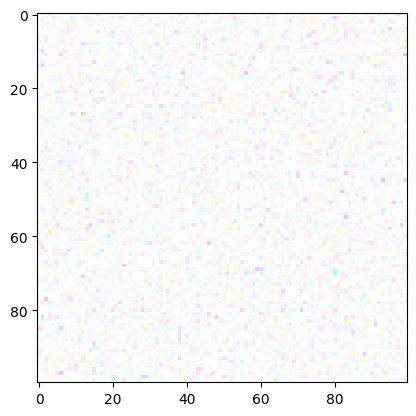

Epoch: 1 | Loss: 0.3407554196175581 


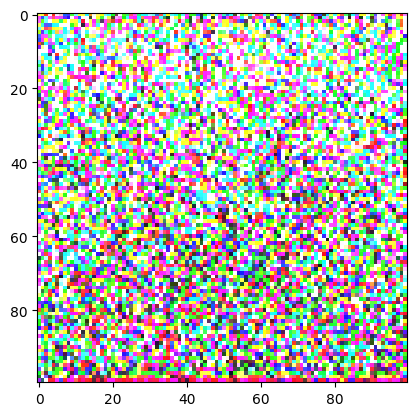

Epoch: 2 | Loss: 0.3352809428871974 


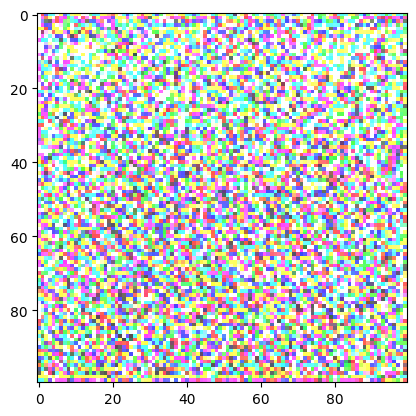

Epoch: 3 | Loss: 0.324534933204175 


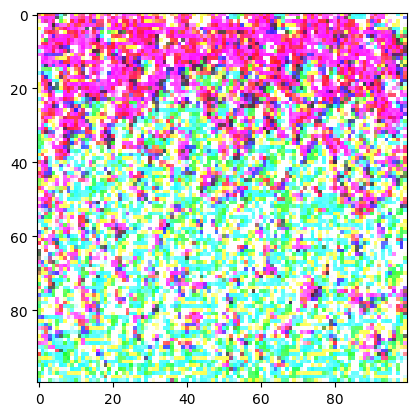

Epoch: 4 | Loss: 0.3626370777401777 


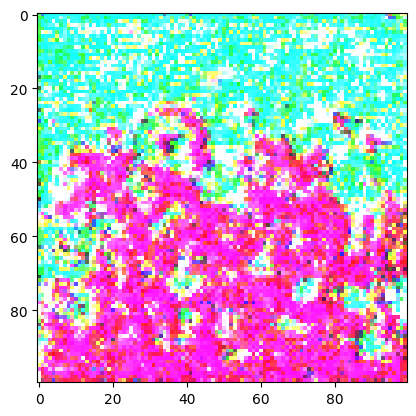

Epoch: 5 | Loss: 0.23809664180055656 


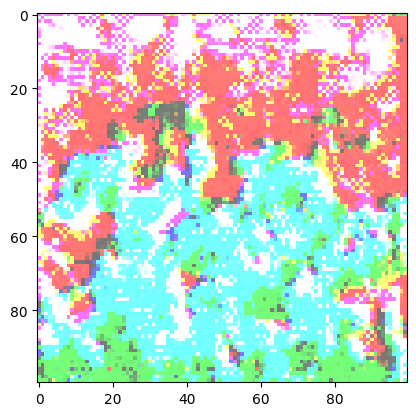

Epoch: 6 | Loss: 0.3667713278975097 


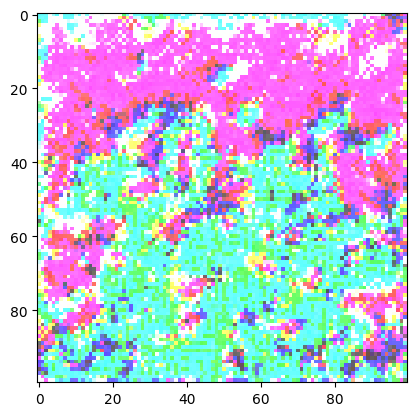

Epoch: 7 | Loss: 0.3394635195584558 


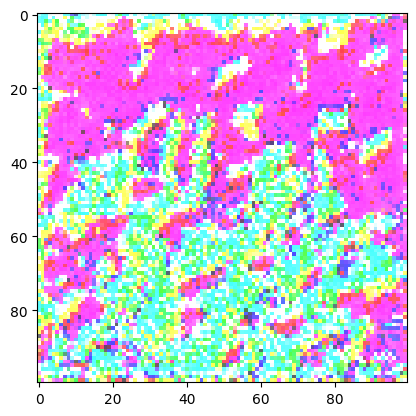

Epoch: 8 | Loss: 0.3561032034275207 


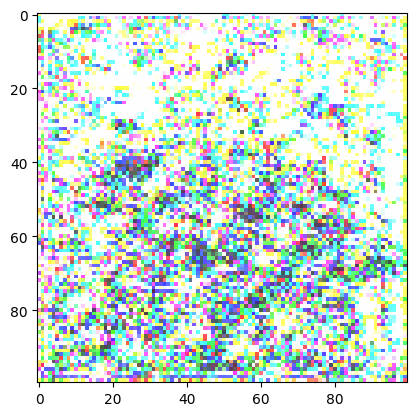

Epoch: 9 | Loss: 0.35443519172240145 


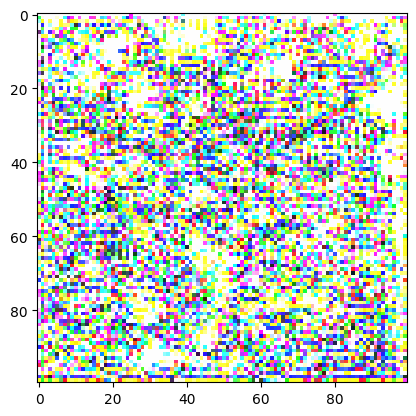

Epoch: 10 | Loss: 0.36950629688780917 


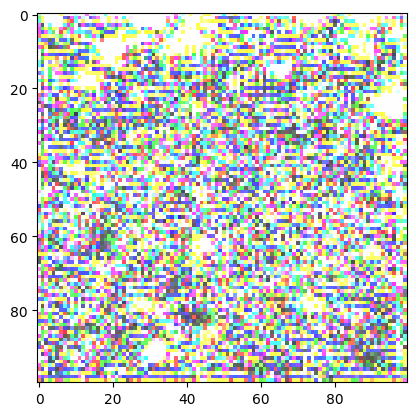

Epoch: 11 | Loss: 0.3647644020083811 


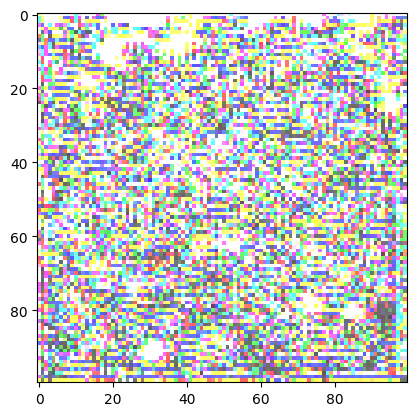

Epoch: 12 | Loss: 0.3958913275256487 


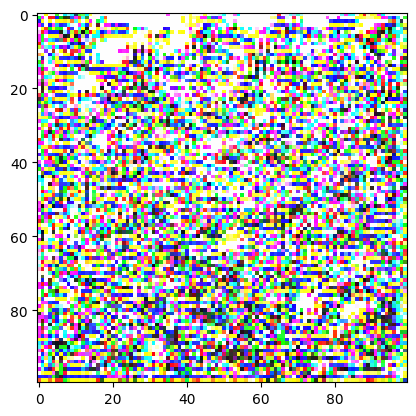

Epoch: 13 | Loss: 0.3506808921530837 


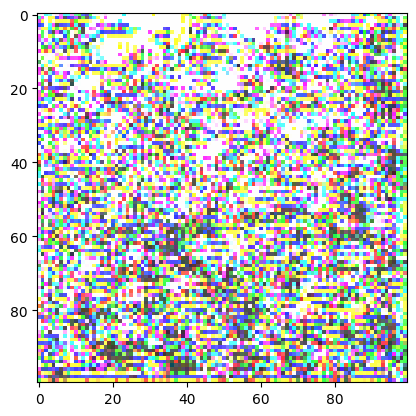

Epoch: 14 | Loss: 0.36576023765190957 


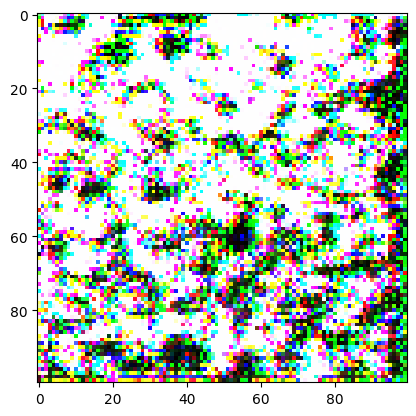

Epoch: 15 | Loss: 0.33244225313377146 


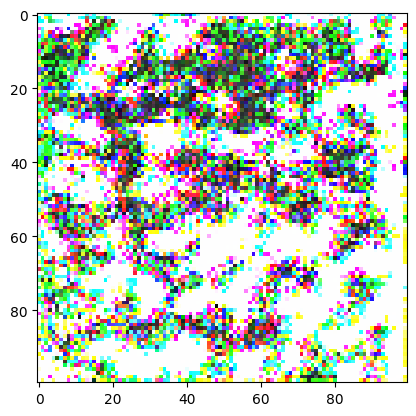

Epoch: 16 | Loss: 0.3684113203024827 


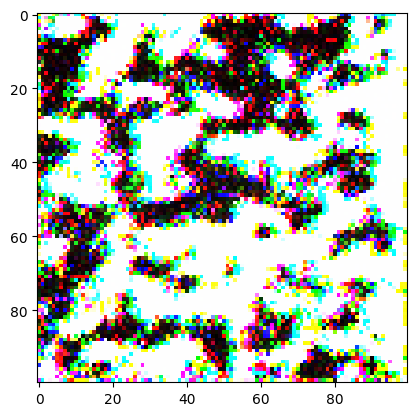

Epoch: 17 | Loss: 0.3755033086786297 


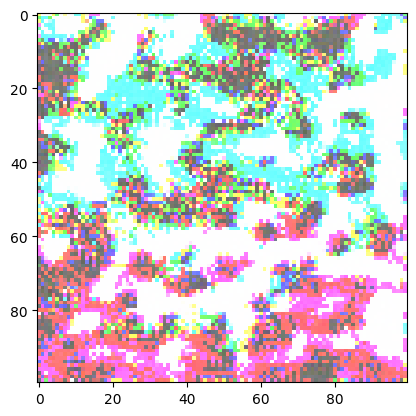

Epoch: 18 | Loss: 0.30977478562308125 


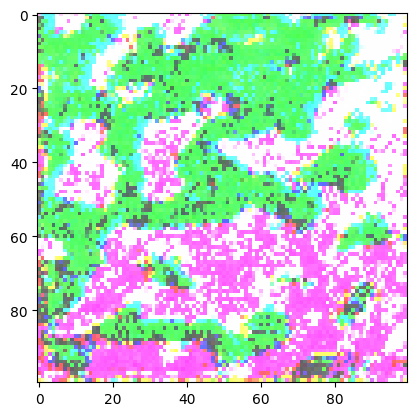

Epoch: 19 | Loss: 0.34146071002712597 


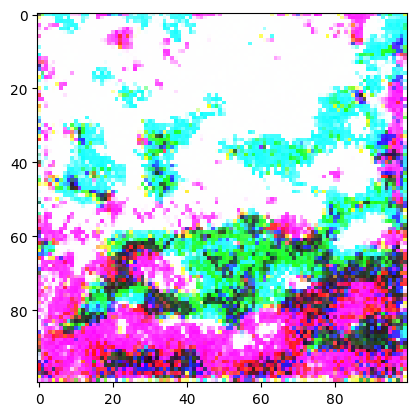

Epoch: 20 | Loss: 0.34059411662970185 


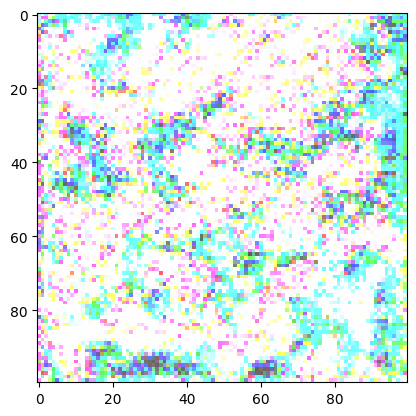

Epoch: 21 | Loss: 0.3633882004894805 


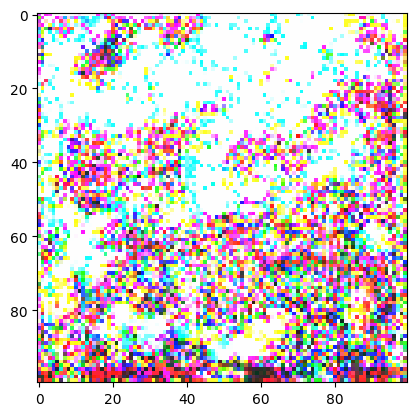

Epoch: 22 | Loss: 0.3533932660771754 


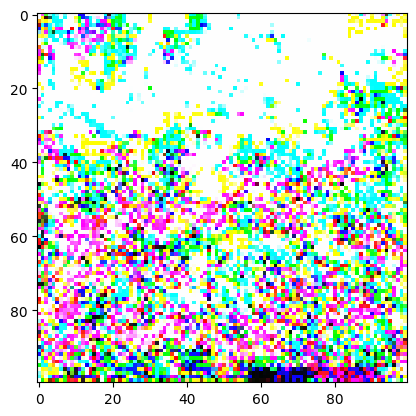

Epoch: 23 | Loss: 0.3567008390596443 


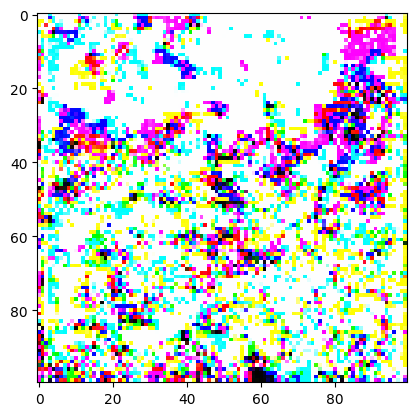

Epoch: 24 | Loss: 0.37388816353475257 


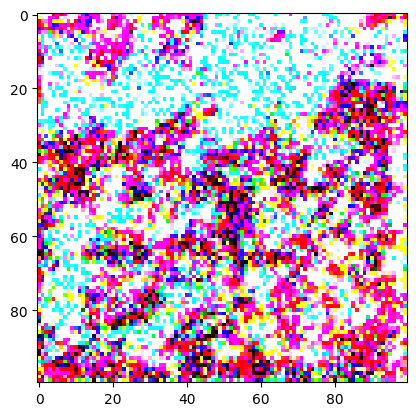

Epoch: 25 | Loss: 0.3574468465694268 


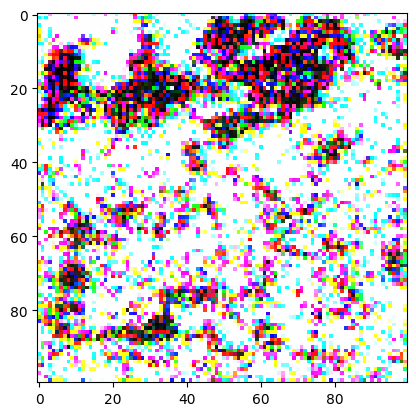

Epoch: 26 | Loss: 0.3794608866950433 


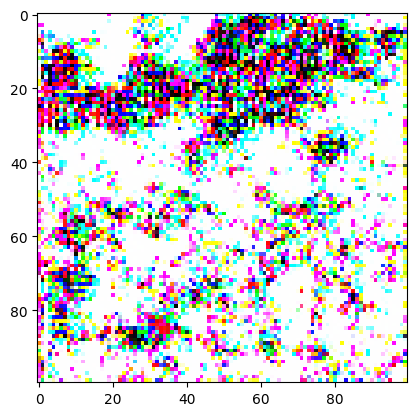

Epoch: 27 | Loss: 0.3645825935299846 


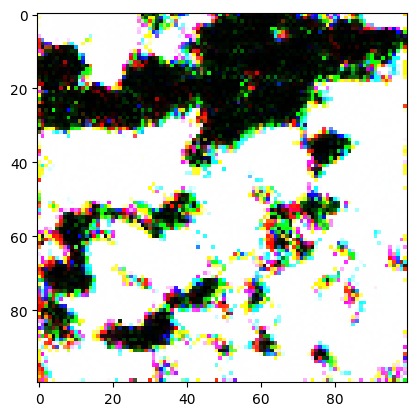

Epoch: 28 | Loss: 0.3708243300367851 


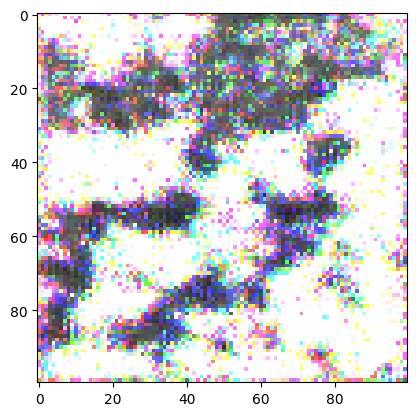

Epoch: 29 | Loss: 0.3310013977348362 


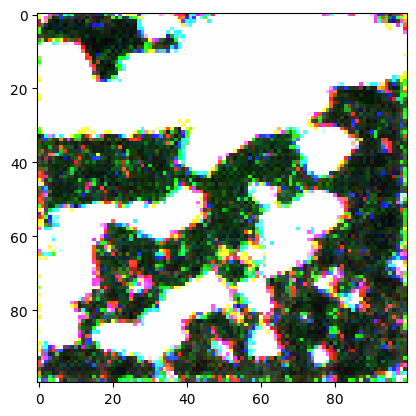

Epoch: 30 | Loss: 0.3508051000749075 


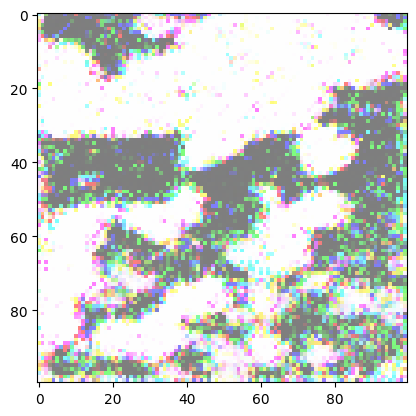

Epoch: 31 | Loss: 0.33668833195373765 


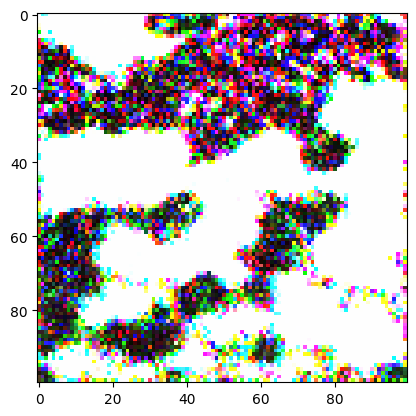

Epoch: 32 | Loss: 0.3565485860480803 


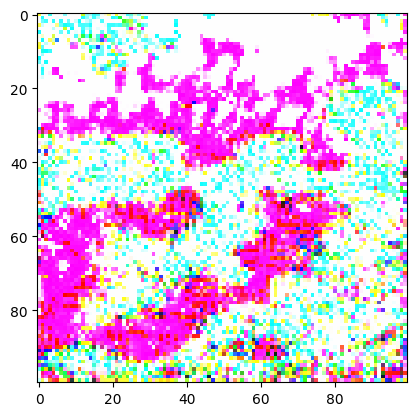

Epoch: 33 | Loss: 0.3431585821746618 


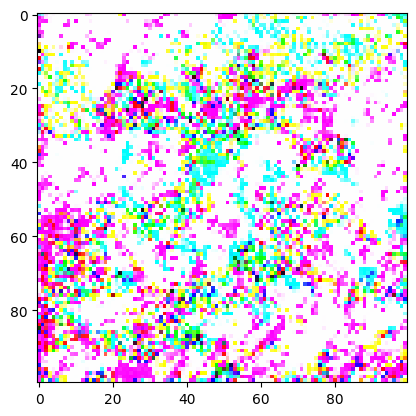

Epoch: 34 | Loss: 0.3518017316276706 


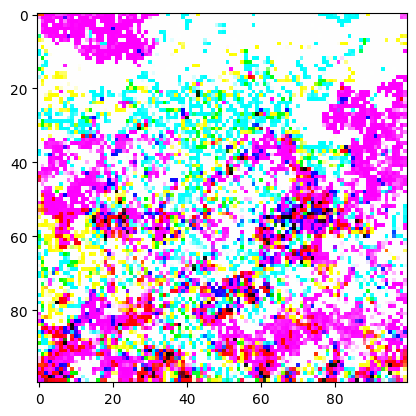

Epoch: 35 | Loss: 0.36710230571009905 


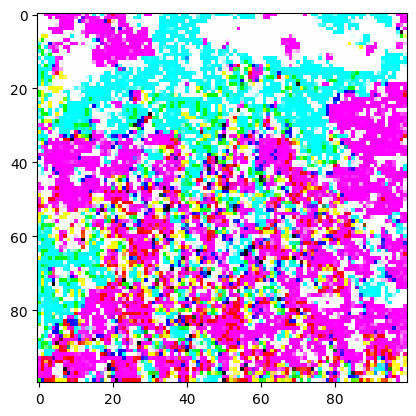

Epoch: 36 | Loss: 0.3662032604537224 


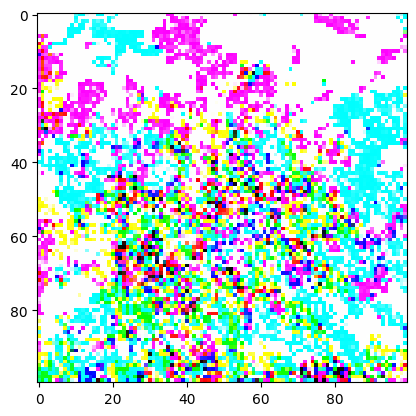

Epoch: 37 | Loss: 0.347507344728024 


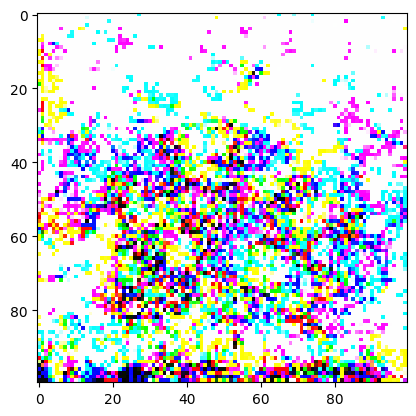

Epoch: 38 | Loss: 0.3779304979293622 


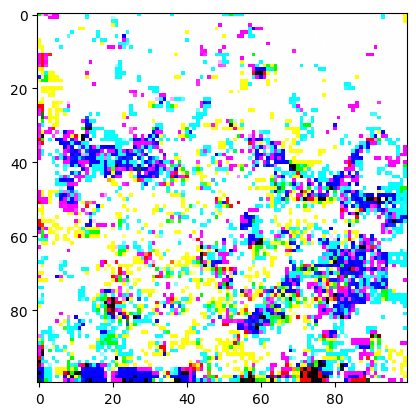

Epoch: 39 | Loss: 0.3343869416296092 


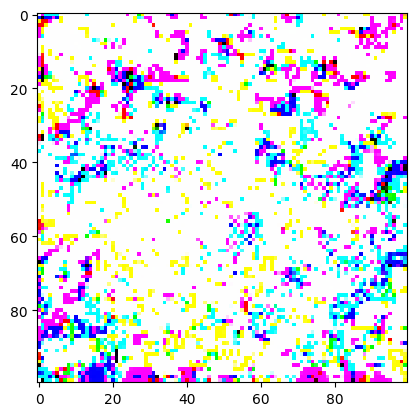

Epoch: 40 | Loss: 0.35263483344159663 


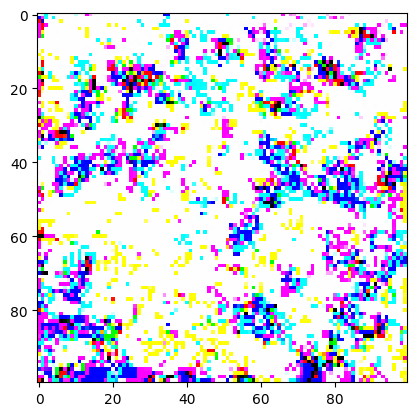

Epoch: 41 | Loss: 0.3694660229875849 


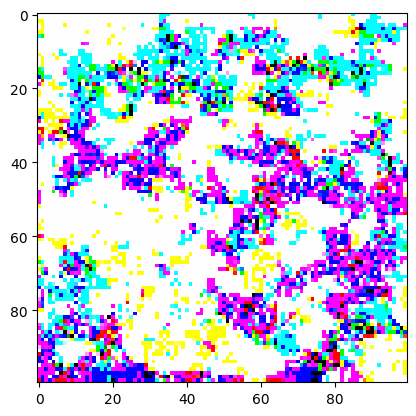

Epoch: 42 | Loss: 0.35051378771726754 


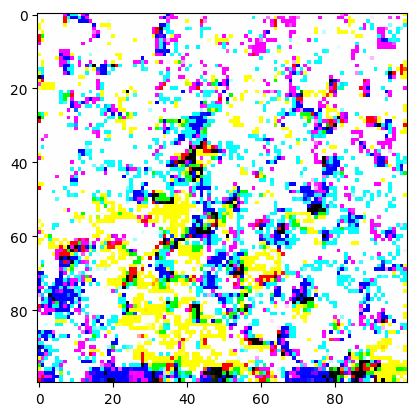

Epoch: 43 | Loss: 0.3439998188250089 


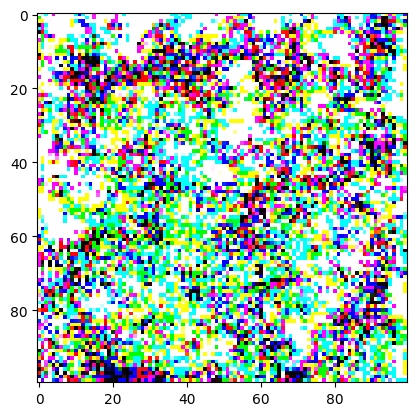

Epoch: 44 | Loss: 0.3712241461096434 


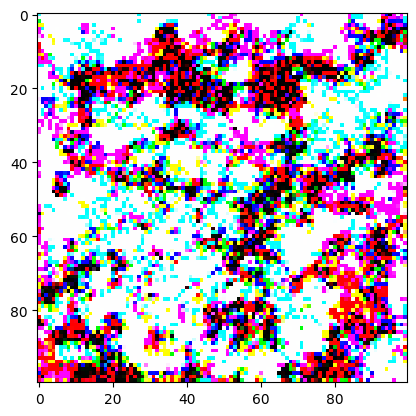

Epoch: 45 | Loss: 0.38080401378331585 


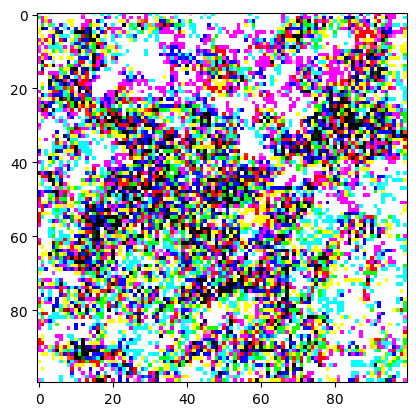

Epoch: 46 | Loss: 0.3719461236466071 


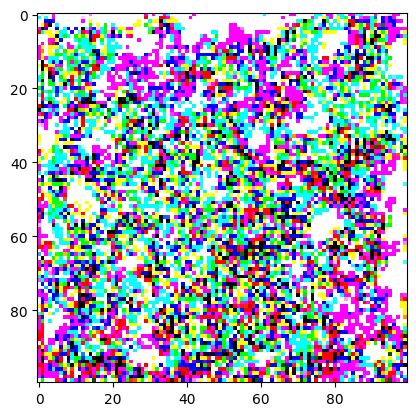

Epoch: 47 | Loss: 0.3814321824939919 


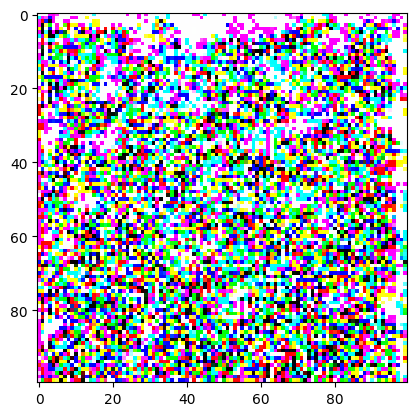

Epoch: 48 | Loss: 0.345390620973498 


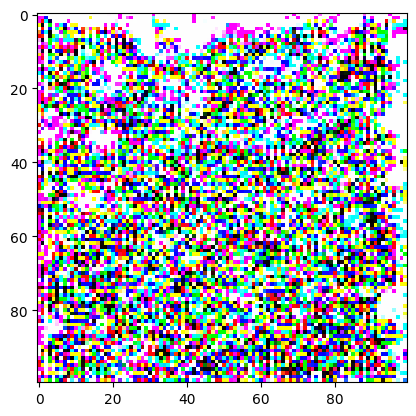

Epoch: 49 | Loss: 0.3721034639891555 


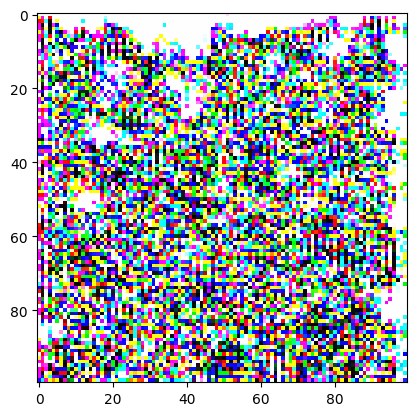

Epoch: 50 | Loss: 0.39021585168778955 


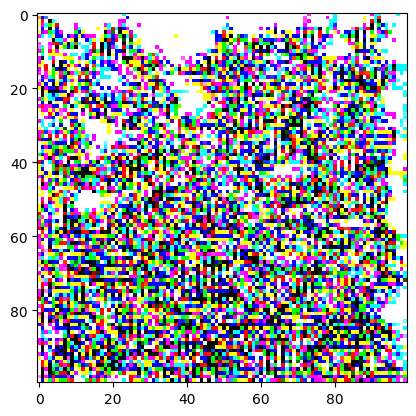

Epoch: 51 | Loss: 0.37266144490675496 


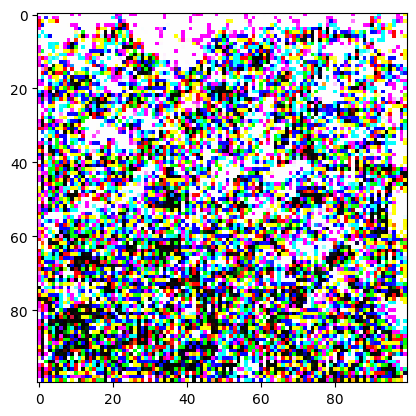

Epoch: 52 | Loss: 0.3804027397285329 


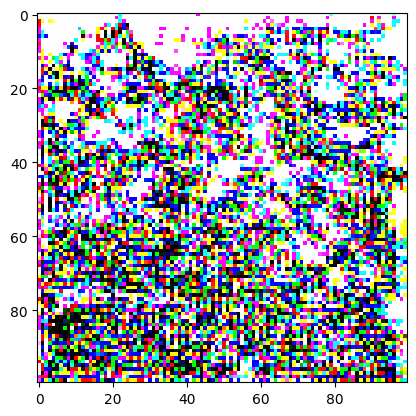

Epoch: 53 | Loss: 0.3734457900696693 


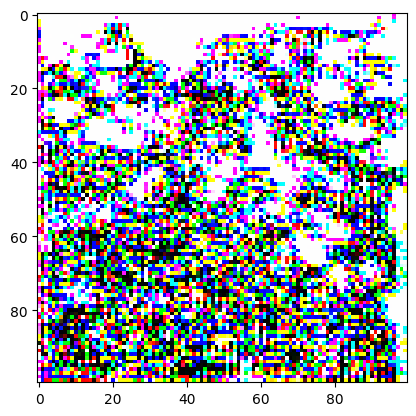

Epoch: 54 | Loss: 0.38908169824180955 


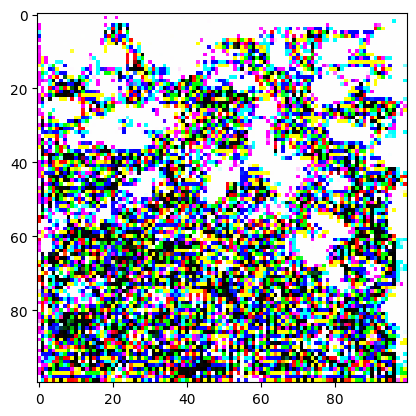

Epoch: 55 | Loss: 0.3318884031306234 


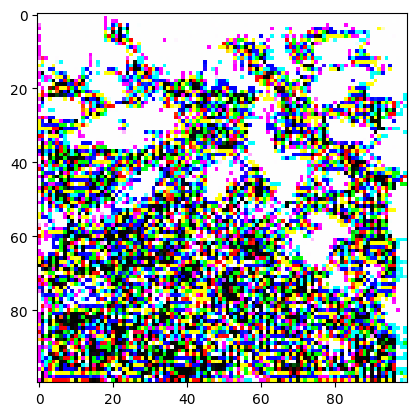

Epoch: 56 | Loss: 0.3705044602798624 


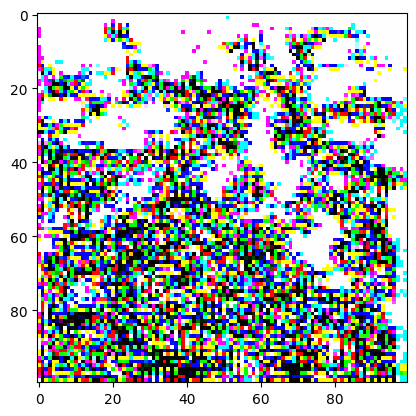

Epoch: 57 | Loss: 0.35730616207222493 


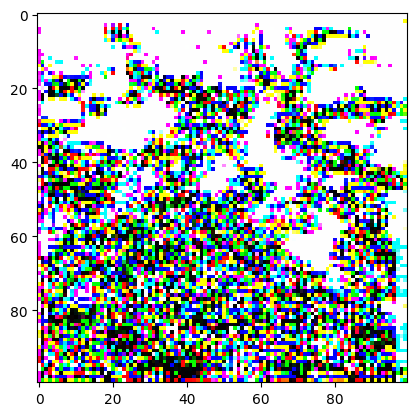

Epoch: 58 | Loss: 0.370151124731445 


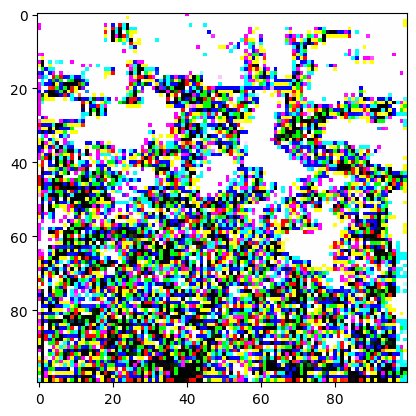

Epoch: 59 | Loss: 0.33405435288382945 


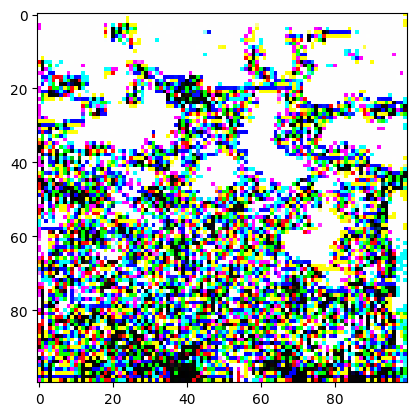

Epoch: 60 | Loss: 0.3697118289801305 


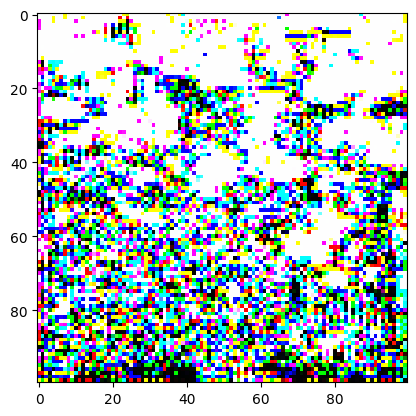

Epoch: 61 | Loss: 0.3727037933059401 


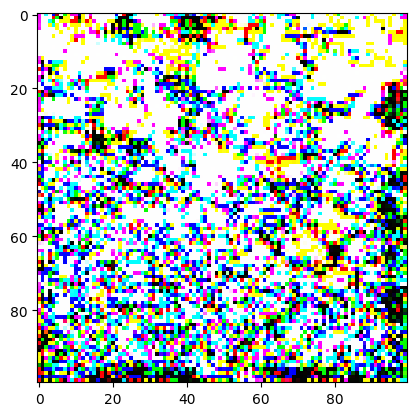

Epoch: 62 | Loss: 0.3543258363905841 


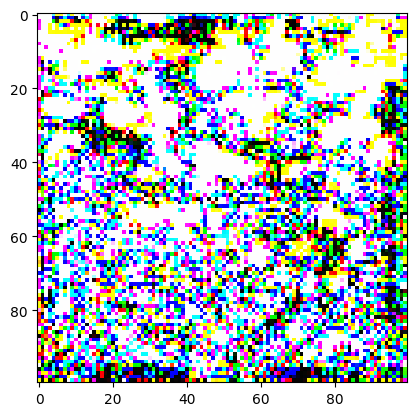

Epoch: 63 | Loss: 0.38805507889745045 


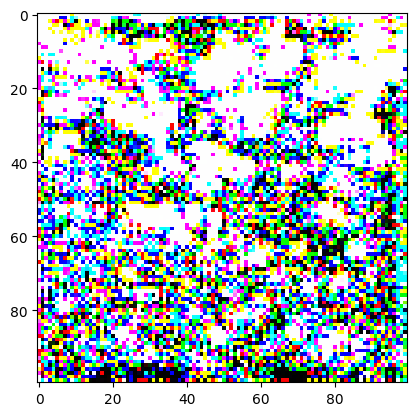

Epoch: 64 | Loss: 0.389800190017012 


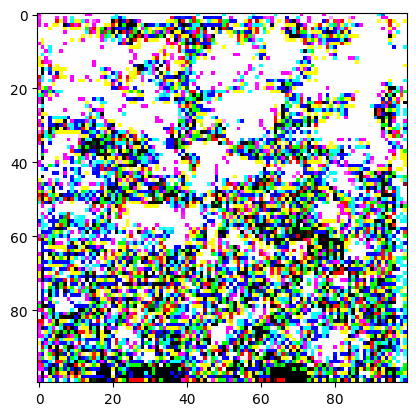

Epoch: 65 | Loss: 0.3519040303041652 


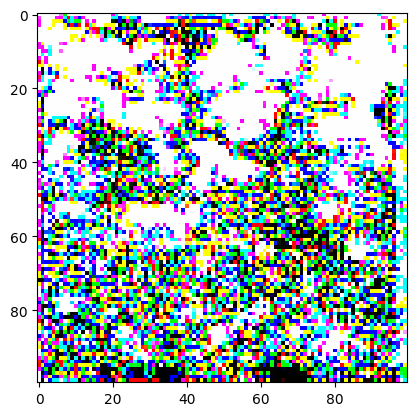

Epoch: 66 | Loss: 0.36583989938989014 


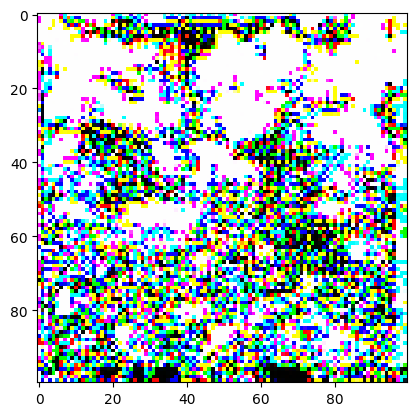

Epoch: 67 | Loss: 0.36745609470391144 


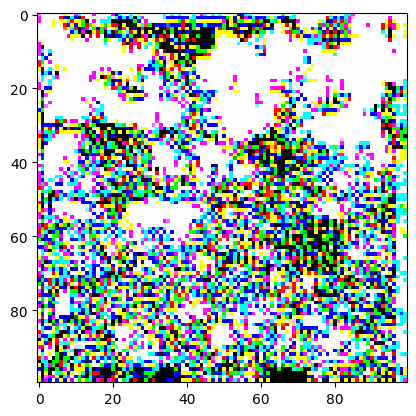

Epoch: 68 | Loss: 0.3687070126376903 


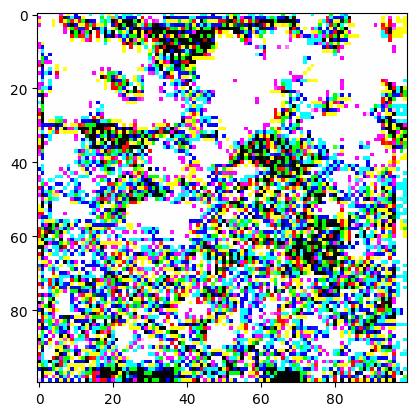

Epoch: 69 | Loss: 0.3831836919116583 


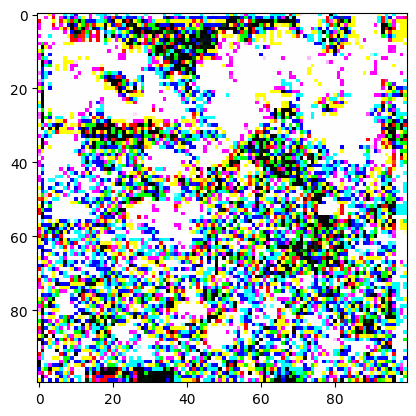

Epoch: 70 | Loss: 0.35922338640513296 


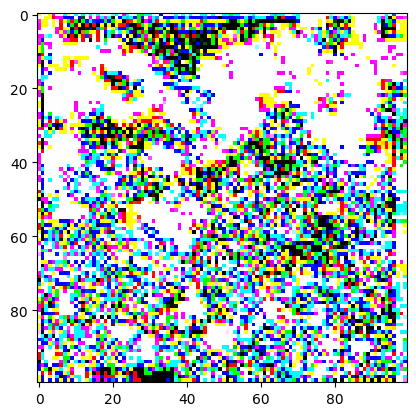

Epoch: 71 | Loss: 0.3781905452006531 


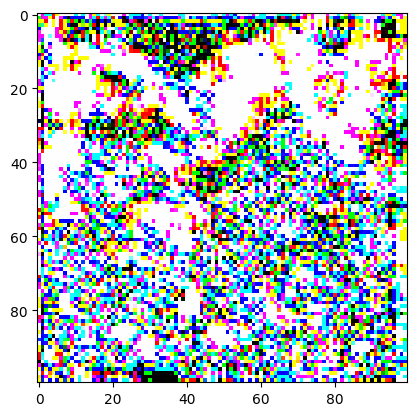

Epoch: 72 | Loss: 0.3783029754797155 


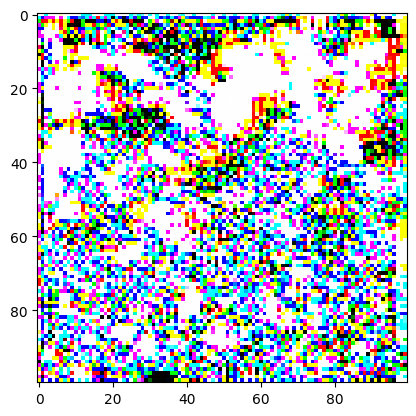

Epoch: 73 | Loss: 0.3451178261349623 


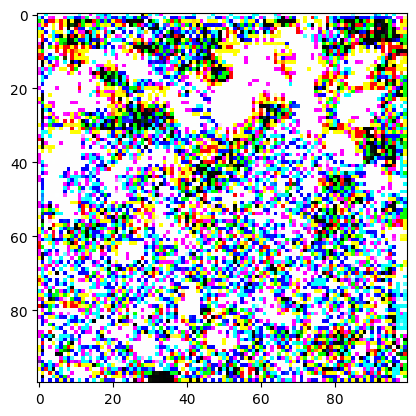

Epoch: 74 | Loss: 0.35606360245332125 


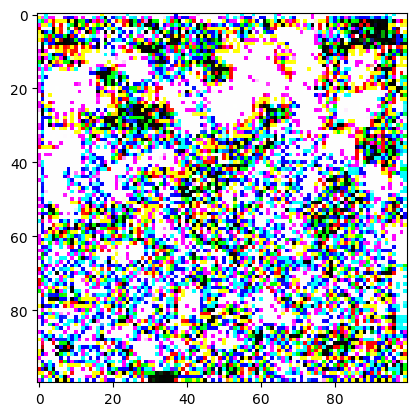

Epoch: 75 | Loss: 0.36974199489760096 


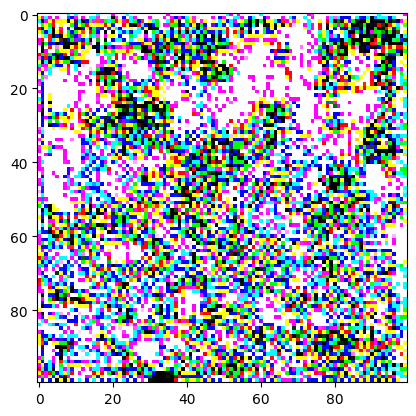

Epoch: 76 | Loss: 0.3745731142117337 


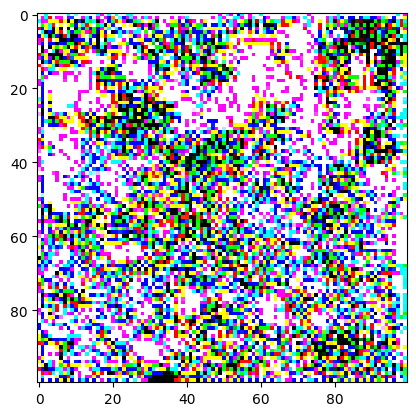

Epoch: 77 | Loss: 0.3790843903112168 


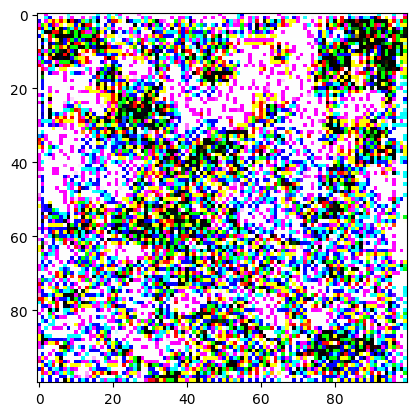

Epoch: 78 | Loss: 0.38181669126949985 


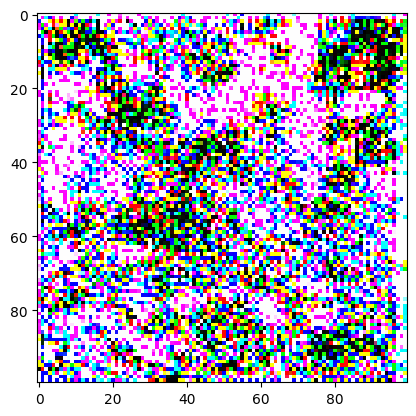

Epoch: 79 | Loss: 0.3693107878694668 


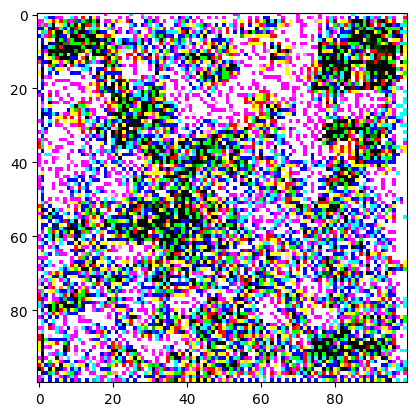

Epoch: 80 | Loss: 0.3715678384036278 


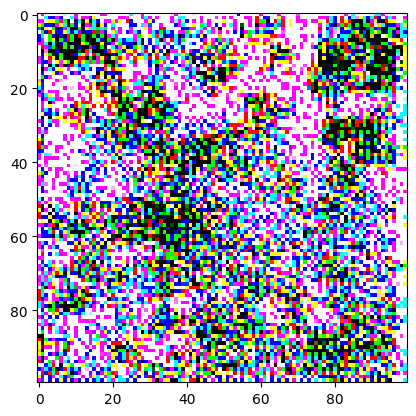

Epoch: 81 | Loss: 0.3730394481784738 


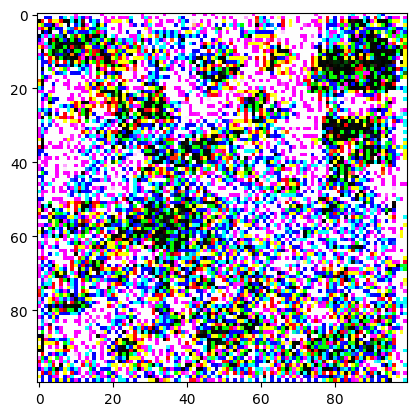

Epoch: 82 | Loss: 0.3998935058120377 


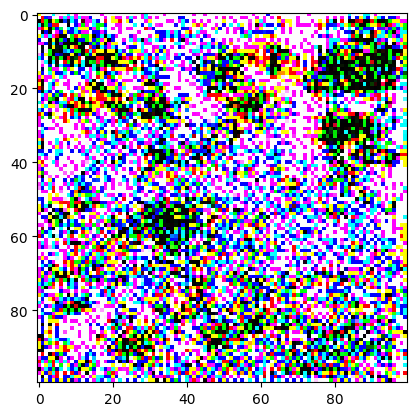

Epoch: 83 | Loss: 0.382309392061809 


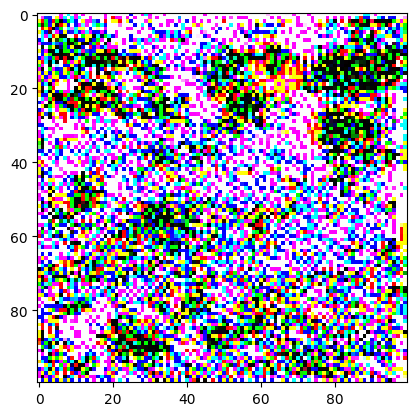

Epoch: 84 | Loss: 0.3440089956203794 


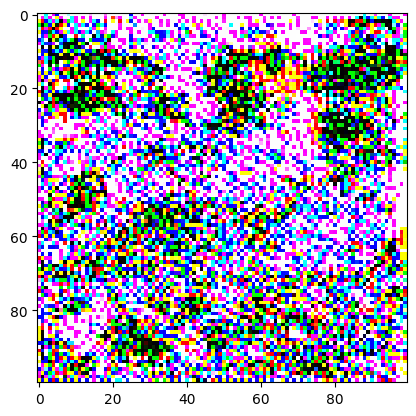

Epoch: 85 | Loss: 0.4070109159638249 


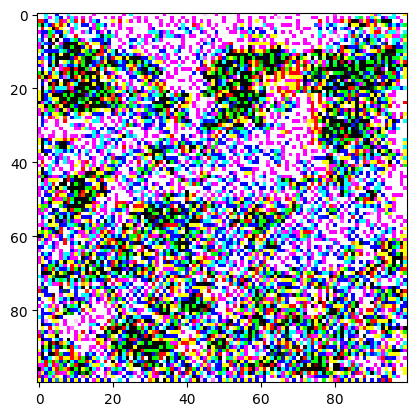

Epoch: 86 | Loss: 0.3850992290315492 


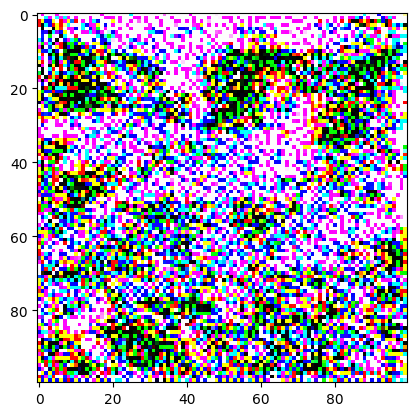

Epoch: 87 | Loss: 0.3869585452588176 


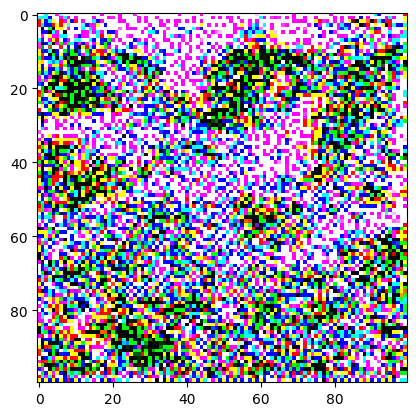

Epoch: 88 | Loss: 0.3568165079314373 


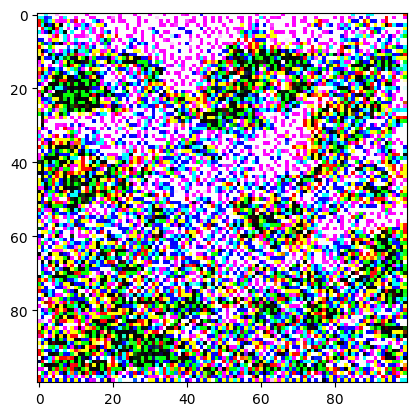

Epoch: 89 | Loss: 0.36244698635880407 


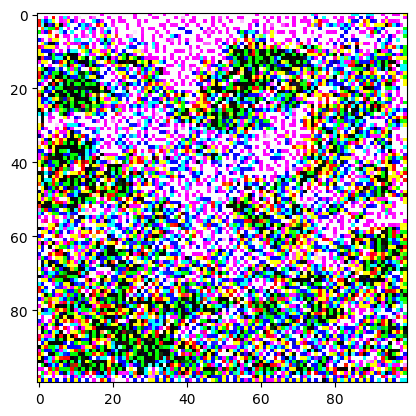

Epoch: 90 | Loss: 0.3690580073540633 


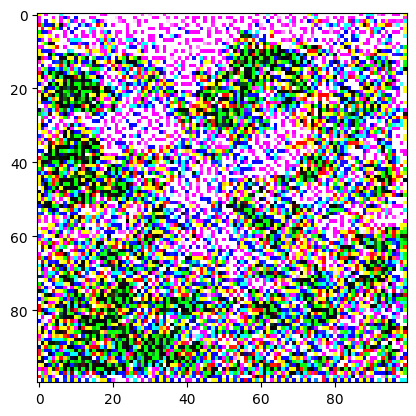

Epoch: 91 | Loss: 0.3411027896712755 


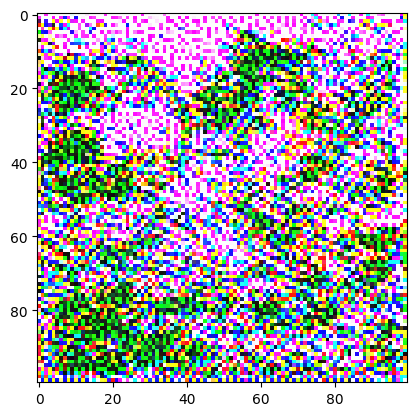

Epoch: 92 | Loss: 0.3695877372611927 


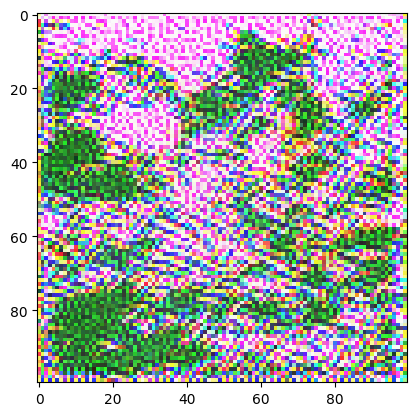

Epoch: 93 | Loss: 0.39211344491228994 


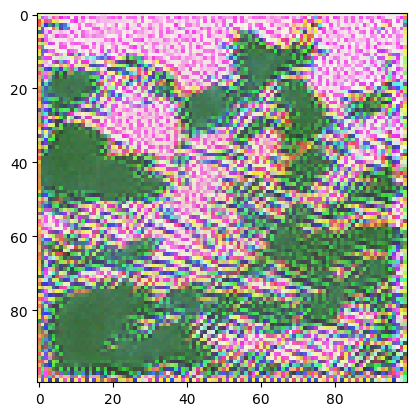

Epoch: 94 | Loss: 0.36086459323781533 


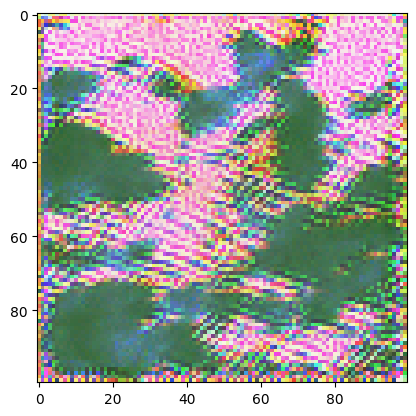

Epoch: 95 | Loss: 0.34838611626897215 


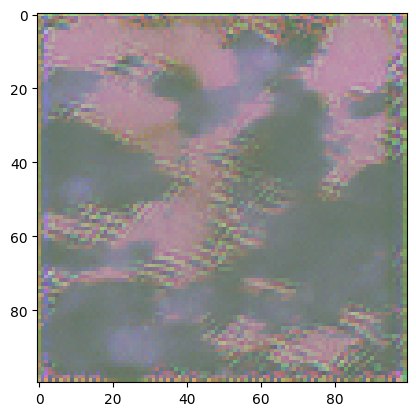

Epoch: 96 | Loss: 0.3745727597643686 


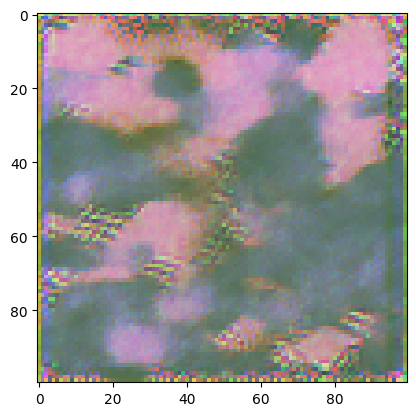

Epoch: 97 | Loss: 0.3534119431810662 


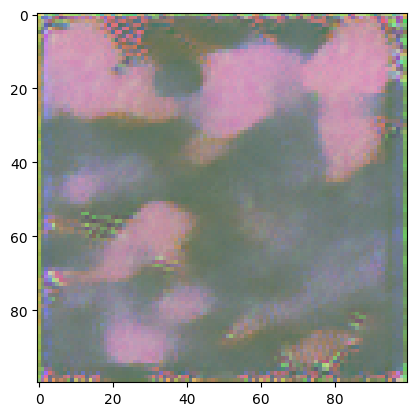

Epoch: 98 | Loss: 0.3224540338431213 


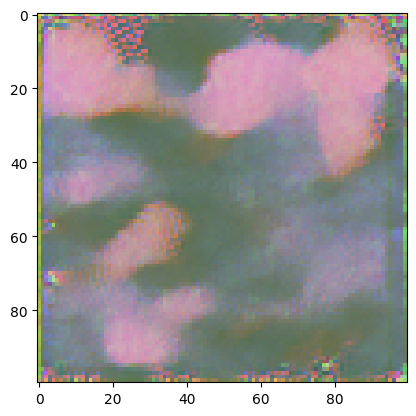

Epoch: 99 | Loss: 0.33906727338226145 


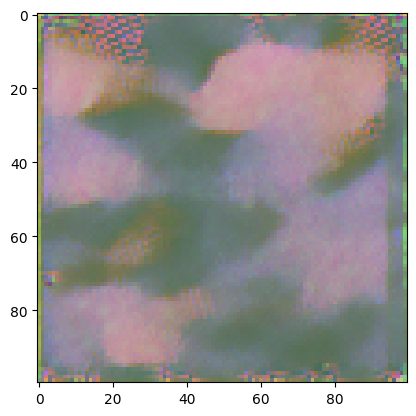

Epoch: 100 | Loss: 0.35257344755492065 


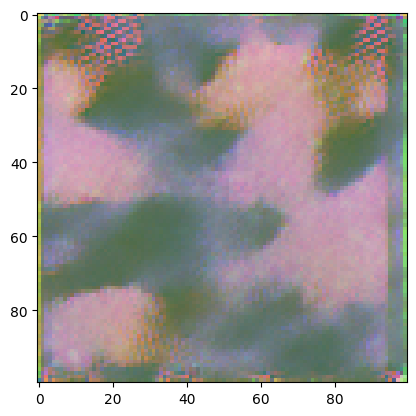

Epoch: 101 | Loss: 0.32721574769583206 


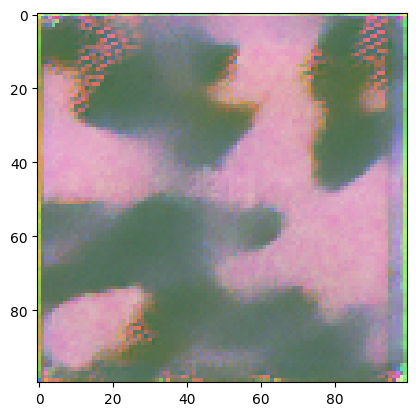

Epoch: 102 | Loss: 0.3467938232178522 


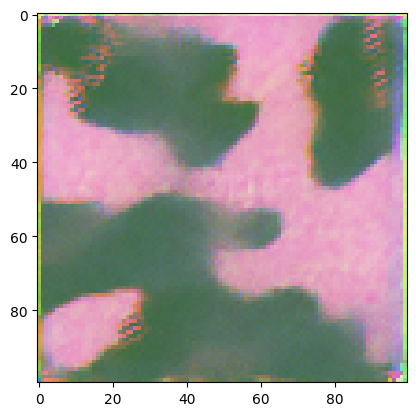

Epoch: 103 | Loss: 0.324594997404769 


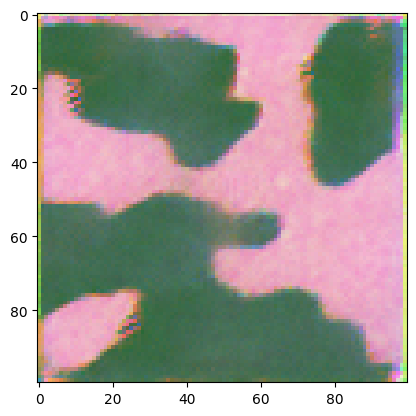

Epoch: 104 | Loss: 0.33052691573959203 


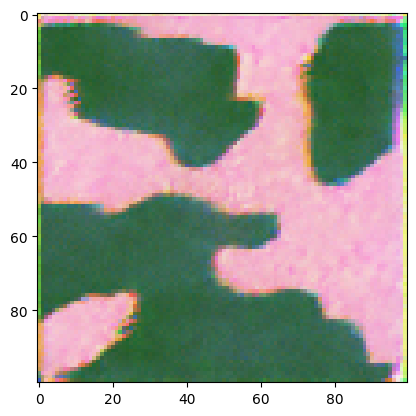

Epoch: 105 | Loss: 0.3386950561047228 


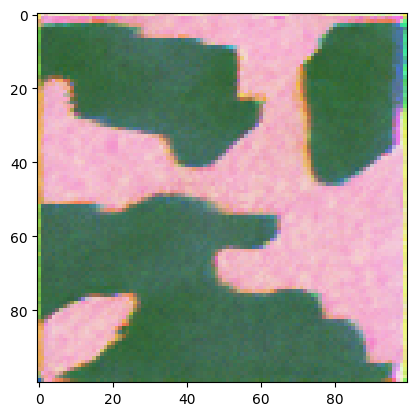

Epoch: 106 | Loss: 0.3497323722018777 


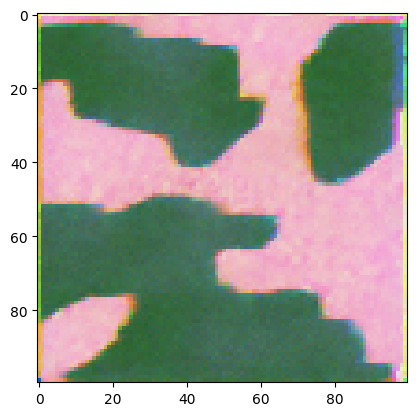

Epoch: 107 | Loss: 0.30744947450672633 


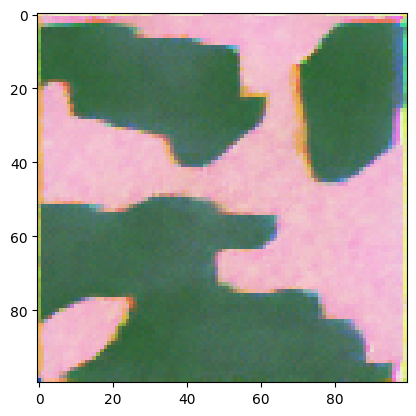

Epoch: 108 | Loss: 0.3516843009891129 


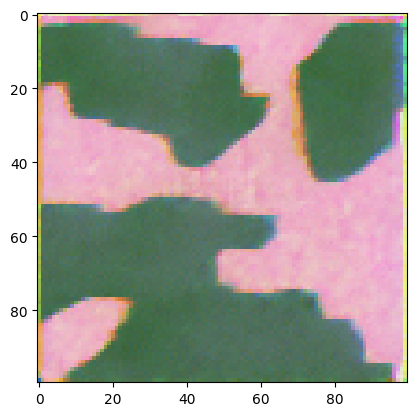

Epoch: 109 | Loss: 0.3476367250183776 


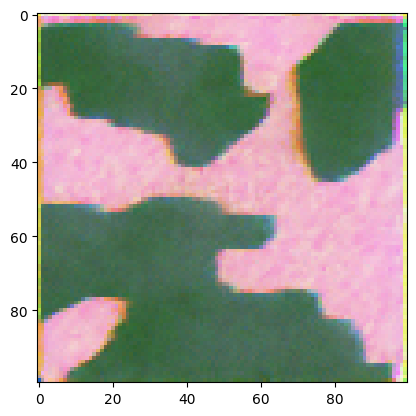

Epoch: 110 | Loss: 0.34869509302675344 


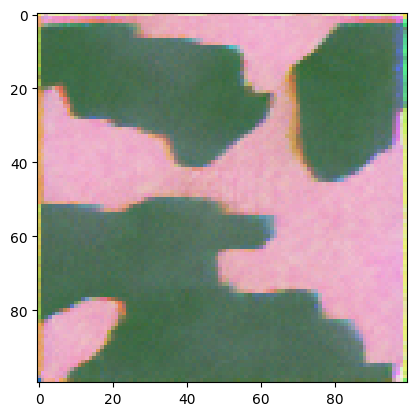

Epoch: 111 | Loss: 0.3461184921004216 


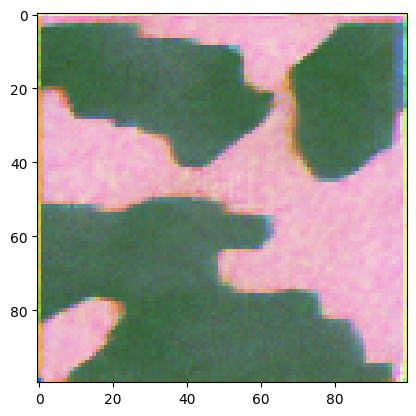

Epoch: 112 | Loss: 0.32798901194852 


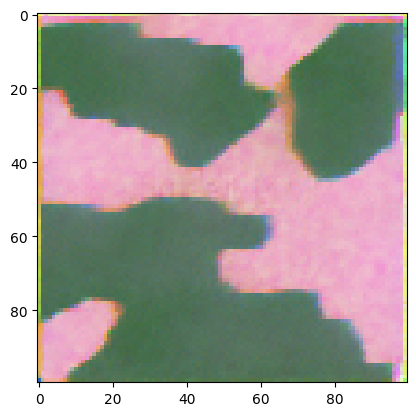

Epoch: 113 | Loss: 0.308271996731758 


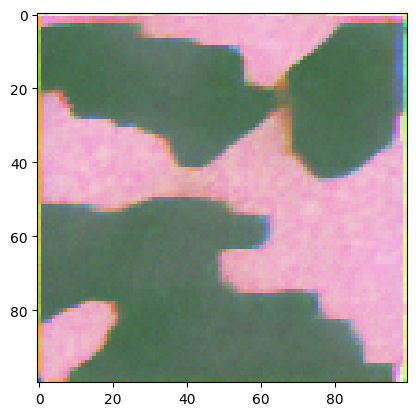

Epoch: 114 | Loss: 0.32444951478145867 


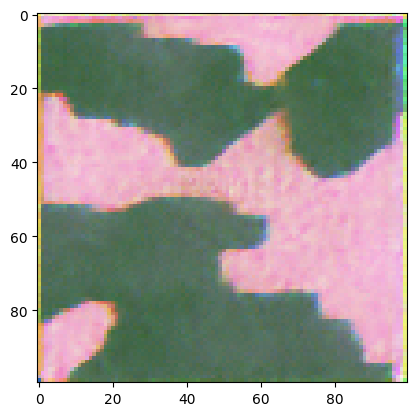

Epoch: 115 | Loss: 0.3138788506649229 


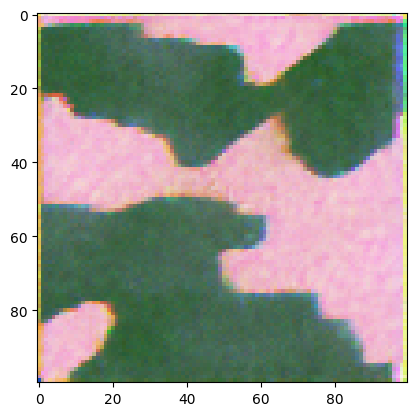

Epoch: 116 | Loss: 0.34227335709703216 


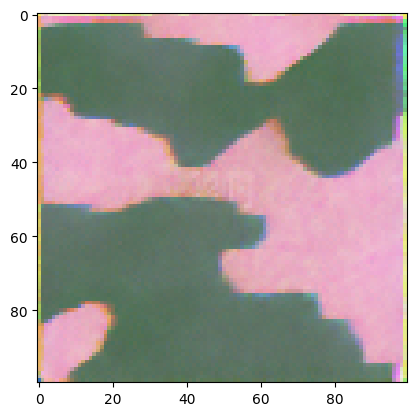

Epoch: 117 | Loss: 0.3254547105809509 


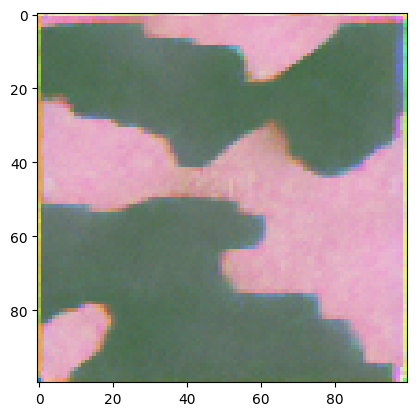

Epoch: 118 | Loss: 0.3200379458572315 


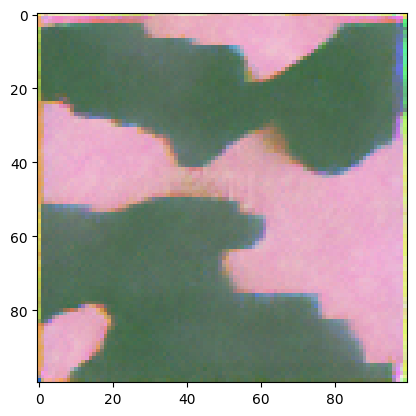

Epoch: 119 | Loss: 0.3526990320159114 


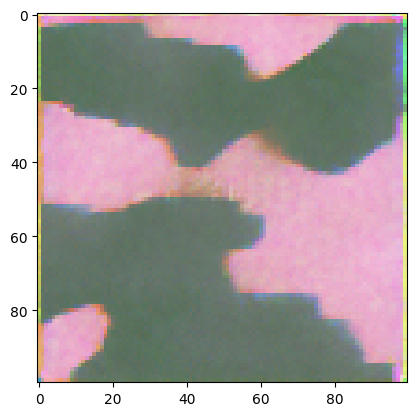

Epoch: 120 | Loss: 0.36392555923844866 


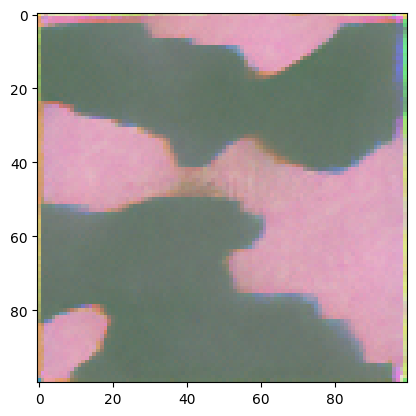

Epoch: 121 | Loss: 0.3593094056329392 


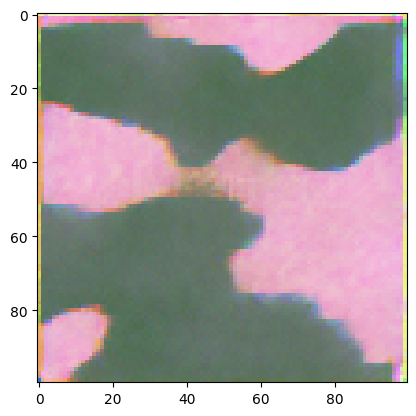

Epoch: 122 | Loss: 0.3471805107036679 


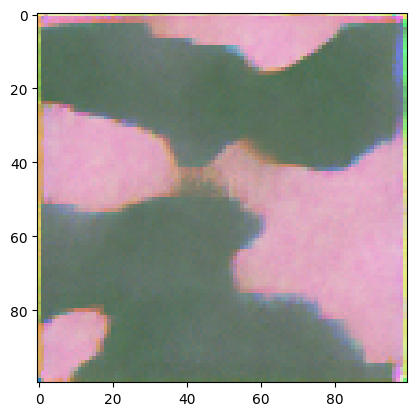

Epoch: 123 | Loss: 0.3353605620459016 


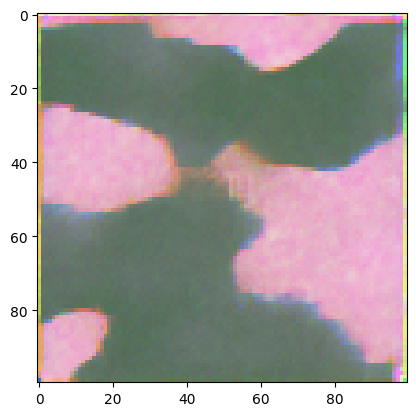

Epoch: 124 | Loss: 0.3239157818517971 


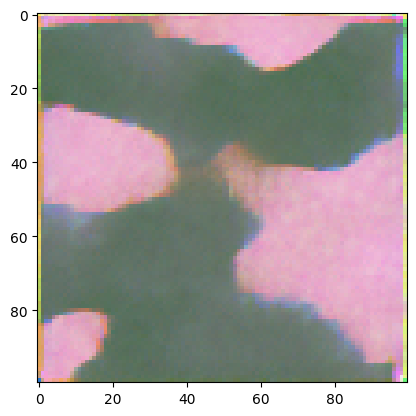

Epoch: 125 | Loss: 0.3298928431259158 


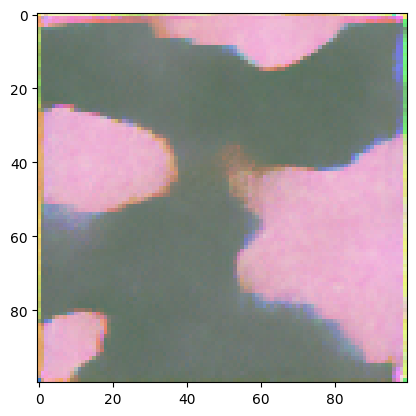

Epoch: 126 | Loss: 0.3322487813017854 


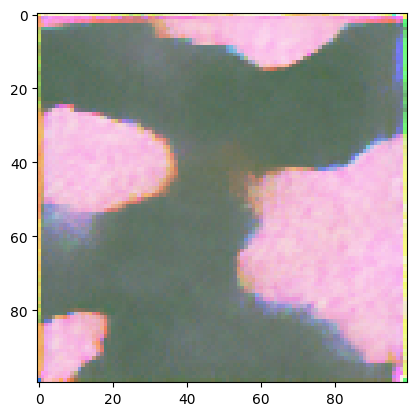

Epoch: 127 | Loss: 0.3311824569277132 


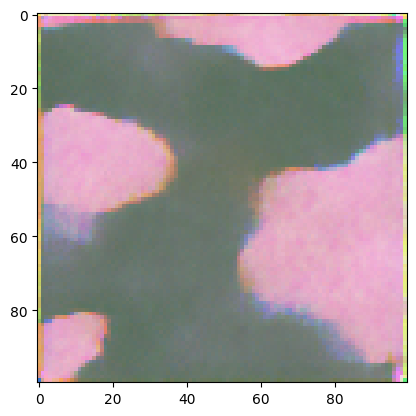

Epoch: 128 | Loss: 0.3691205268936961 


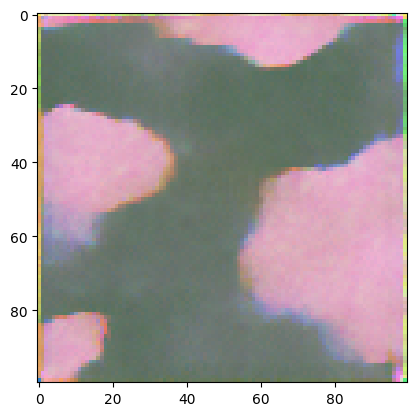

Epoch: 129 | Loss: 0.3452481713511578 


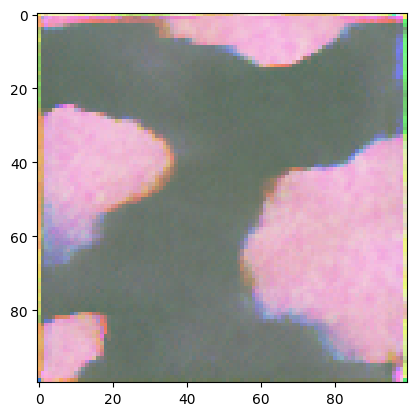

Epoch: 130 | Loss: 0.3367907969789352 


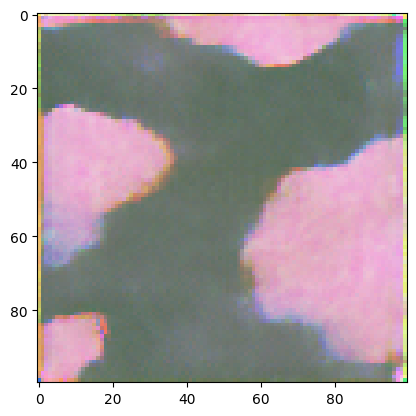

Epoch: 131 | Loss: 0.3348488456056875 


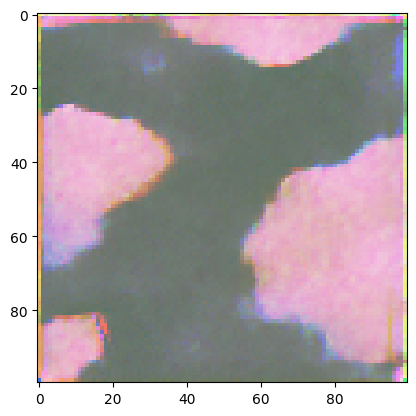

Epoch: 132 | Loss: 0.3478178216478777 


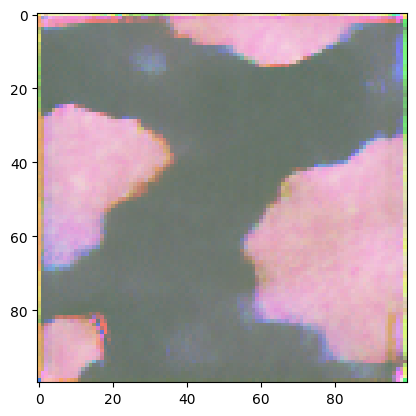

Epoch: 133 | Loss: 0.339125160342277 


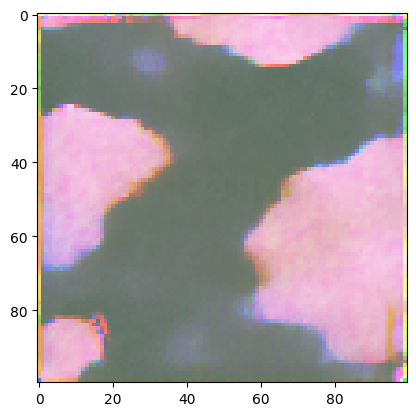

Epoch: 134 | Loss: 0.3580697755779487 


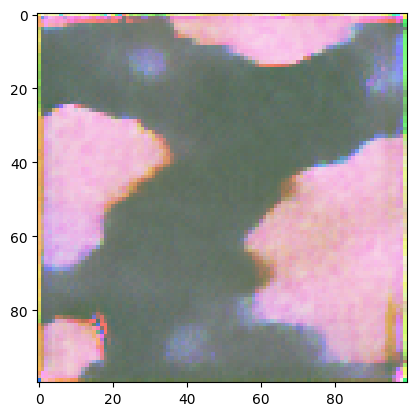

Epoch: 135 | Loss: 0.3522041778170665 


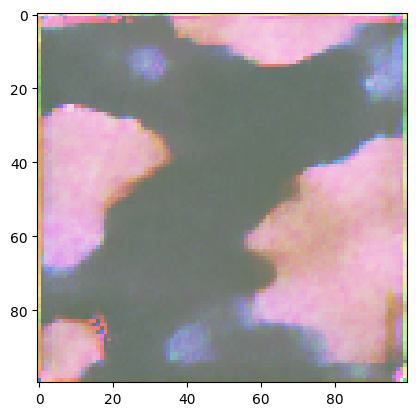

Epoch: 136 | Loss: 0.3445722947082472 


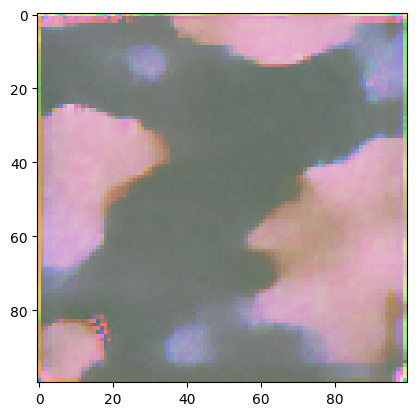

Epoch: 137 | Loss: 0.33032926887492353 


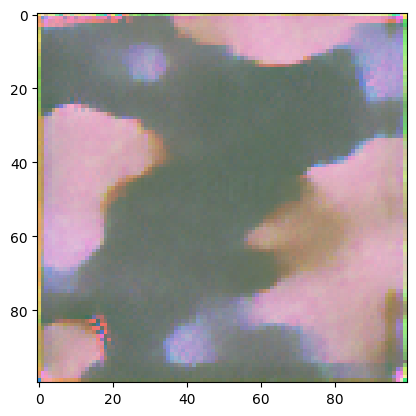

Epoch: 138 | Loss: 0.33050319627418395 


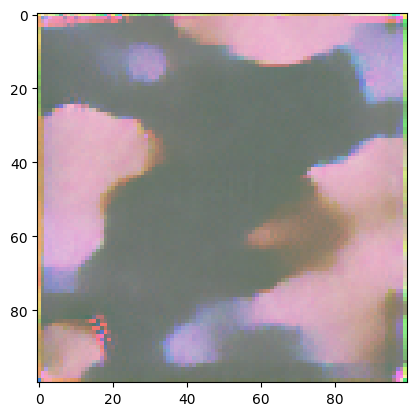

Epoch: 139 | Loss: 0.3342290666256973 


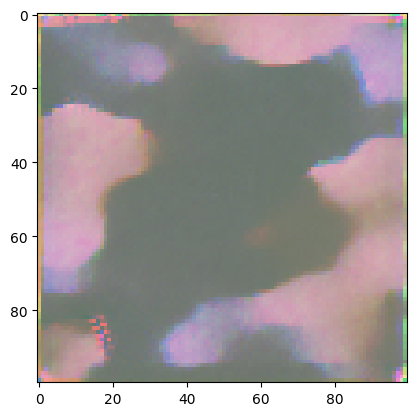

Epoch: 140 | Loss: 0.3429862391615977 


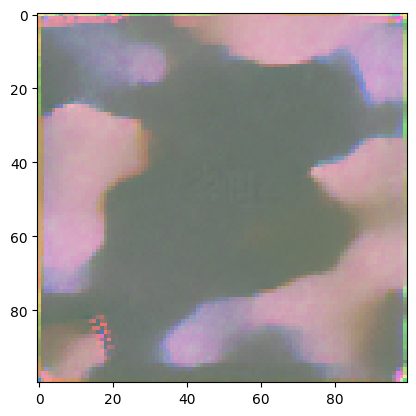

Epoch: 141 | Loss: 0.3526192280117758 


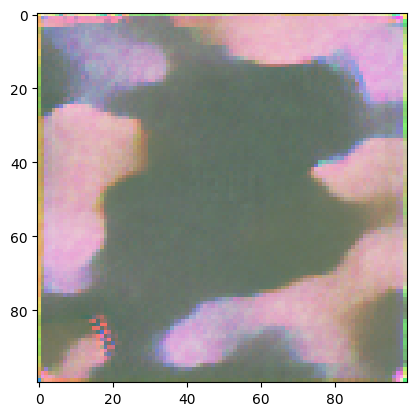

Epoch: 142 | Loss: 0.35886192432423425 


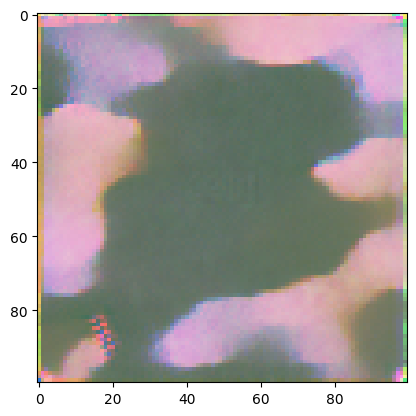

Epoch: 143 | Loss: 0.3253872870844772 


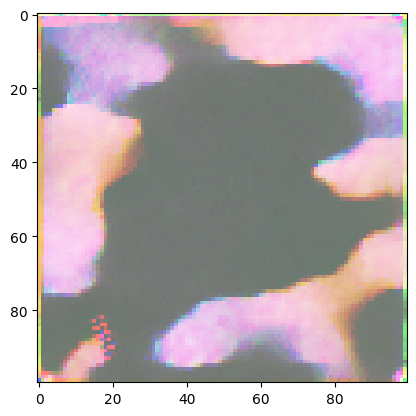

Epoch: 144 | Loss: 0.35323062366994523 


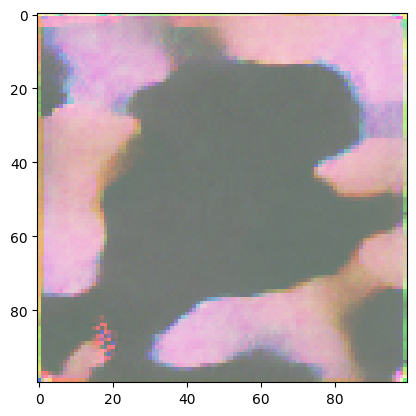

Epoch: 145 | Loss: 0.33897050625742176 


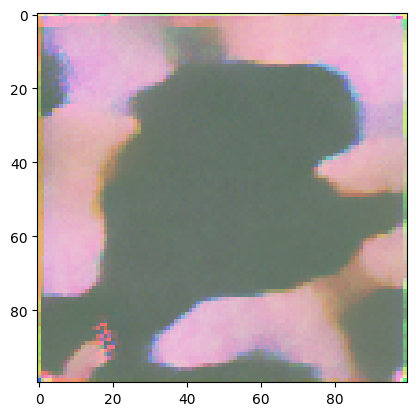

Epoch: 146 | Loss: 0.31993044478221444 


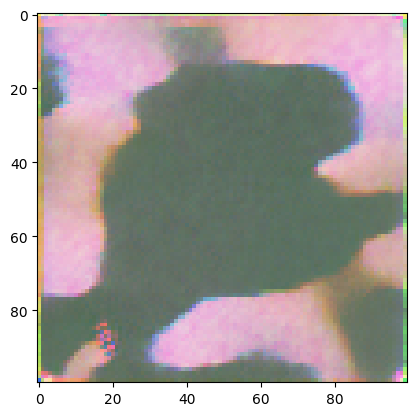

Epoch: 147 | Loss: 0.3328155652927027 


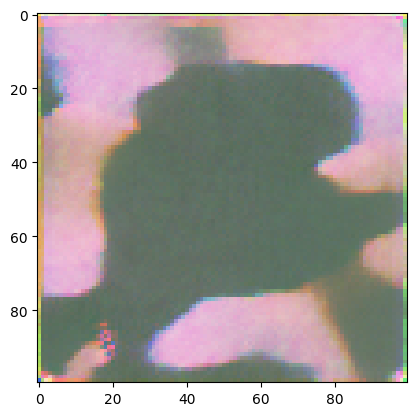

Epoch: 148 | Loss: 0.3279167068188045 


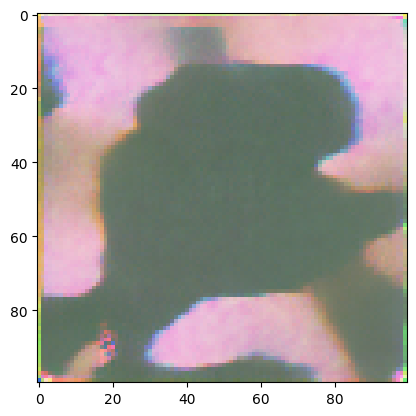

Epoch: 149 | Loss: 0.3354233430048511 


In [ ]:
# Constant data used for calculating discriminator loss
fake_discriminator_actual = torch.zeros(
    (BATCH_SIZE, 1), dtype=torch.float64, device=DEVICE)
valid_discriminator_actual = torch.ones(
    (BATCH_SIZE, 1), dtype=torch.float64, device=DEVICE)

for epoch in range(1, 150):

  epoch_loss = 0

  image_generator.train()
  discriminator.train()

  for in_batch, trg_batch in training_dataloader:


    # Skip this batch if it is None
    if in_batch is None or trg_batch is None:
      continue
    # Skip this batch if the target images have invalid RGB values
    if torch.isnan(trg_batch).any() or torch.isinf(trg_batch).any():
        continue

    ## DISCRIMINATOR'S TURN ##
    discriminator_optimizer.zero_grad()

    # Ensure CUDA is used (if enabled)
    in_batch = in_batch.to(DEVICE)
    # Permute the target batch (PIL uses images of size (H, W, C), but
    # PyTorch requires them to be of shape (C, H, W))
    trg_batch = trg_batch.permute(0, 3, 1, 2).to(DEVICE)

    # "fake_input" simulates randomized token indices
    fake_input = torch.rand((BATCH_SIZE, MAX_INPUT_LENGTH), device=DEVICE)

    # Scale decimal values by vocab length - 1, then add 1
    # to avoid padding values
    fake_input = fake_input * (VOCAB_SIZE - 1) + 1

    # Convert fake_input to integer sequences
    fake_input = fake_input.long()

    # Generate image output to be evaluated by discriminator
    fake_images = image_generator(fake_input).view(
        BATCH_SIZE, 3, HEIGHT, WIDTH)

    # Discriminator aims to output 0 for any images generated by the model
    fake_pred_y = discriminator(fake_images)
    fake_loss = adversarial_loss(fake_pred_y, fake_discriminator_actual)

    # Discriminator aims to output 1 for images present in the dataset
    real_pred_y = discriminator(trg_batch)
    real_loss = adversarial_loss(real_pred_y, valid_discriminator_actual)

    # Use the mean of the two discriminator losses (for valid and fake images)
    # as the final discriminator loss
    discriminator_loss = (actual_loss + fake_loss) / 2

    discriminator_loss.backward()
    discriminator_optimizer.step()

    ## GENERATOR'S TURN ##
    generative_optimizer.zero_grad()

    # Predict images based on input sequence
    prediction = image_generator(in_batch).view(
        BATCH_SIZE,3,HEIGHT,WIDTH)

    # Generator's loss is the difference b/w the discriminator's evaluation
    # of the output and 1.
    generative_loss = adversarial_loss(
        discriminator(prediction), valid_discriminator_out)

    # Teacher forcing (see prior text box for info)
    if random.random() >= TEACHER_FORCING_RATIO:

        # Use ssim to get the (size-averaged) similarity between
        # predicted images and actual images
        image_loss = 1 - ssim(
            prediction, trg_batch, data_range = 1.0, win_size = 3)
        # Take the mean of the discriminator's prediction
        generative_loss = (generative_loss + image_loss) / 2

        TEACHER_FORCING_RATIO += TEACHER_FORCING_GAMMA

    # Add current loss to the total epoch loss
    epoch_loss += generative_loss.detach().item()

    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)

    # Backward pass
    generative_loss.backward()
    generative_optimizer.step()

  # Evaluate accuracy of generator
  evaluate(image_generator, image_discriminator)
  # Print the loss for this epoch
  print(f"Epoch: {epoch} | Loss: {total_loss / len(data_loader)} ")

In [ ]:
image_generator.eval()

for input_seq, _ in valid_dataset.take(10):

  input_text_sequence = " ".join([vocab_itos[t] for t in input_seq.tolist()])
  print(input_text_sequence)

  generated_image = image_generator(input_seq.unsqueeze(0)).max(0)[0]

  generated_image = generated_image.view((1, HEIGHT,WIDTH, 3)).squeeze().detach().cpu().numpy()

  # Display the generated image
  plt.imshow(prediction)
  plt.show()